strength
 1    369
 0    336
-1    303
Name: count, dtype: int64


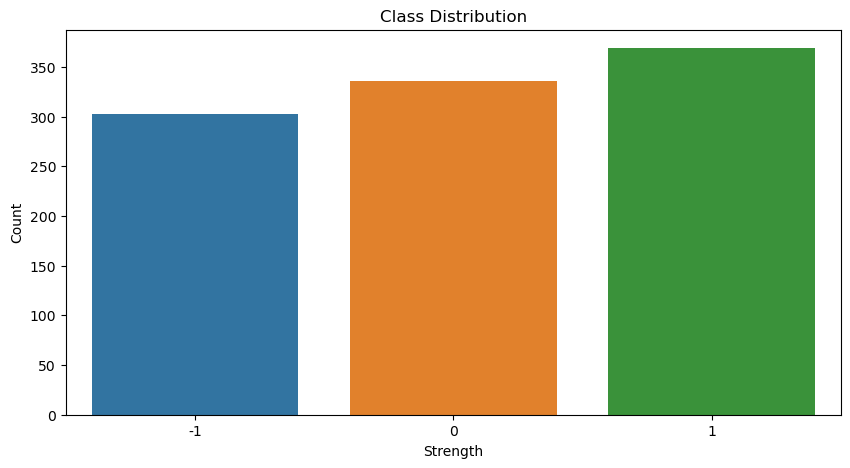

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
features = pd.read_csv('word2vec_features_notcleaneddata.csv')

# Check the distribution of the 'strength' classes
class_counts = features['strength'].value_counts()
print(class_counts)

# Plotting the class distribution
plt.figure(figsize=(10, 5))
sns.countplot(x='strength', data=features)
plt.title('Class Distribution')
plt.xlabel('Strength')
plt.ylabel('Count')
plt.show()


In [4]:
pip uninstall scikit-learn

^C
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [6]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Separate features and labels
X = features['embedding'].apply(lambda x: np.fromstring(x.strip('[]'), sep=',')).tolist()
y = features['strength'].values

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE only to the training data
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Check the new class distribution after SMOTE
print("New class distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())


ImportError: cannot import name 'parse_version' from 'sklearn.utils' (D:\Anaconda\Lib\site-packages\sklearn\utils\__init__.py)

In [1]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk

# Download NLTK data files (only needed once)
nltk.download('punkt')

# Load dataset
data = pd.read_excel('Audio_data_final_notcleaned.xlsx')

# Tokenize the questions and answers
data['tokens'] = (data['Question'] + ' ' + data['Answer']).apply(word_tokenize)

# Train a Word2Vec model
word2vec_model = Word2Vec(sentences=data['tokens'].tolist(), vector_size=100, window=5, min_count=1, workers=4)

# Function to get Word2Vec embeddings for a text
def get_word2vec_embeddings(tokens):
    embeddings = []
    for token in tokens:
        if token in word2vec_model.wv:
            embeddings.append(word2vec_model.wv[token])
    if not embeddings:  # If no tokens found, return a zero vector
        return np.zeros(word2vec_model.vector_size)
    return np.mean(embeddings, axis=0)  # Average the embeddings

# Create a new list to hold the features for Word2Vec
w2v_features = []

for index, row in data.iterrows():
    tokens = word_tokenize(row['Question'] + ' ' + row['Answer'])
    embedding = get_word2vec_embeddings(tokens)

    w2v_features.append({
        'question': row['Question'],
        'answer': row['Answer'],
        'strength': row['Strength'],
        'embedding': embedding
    })

# Convert the features to DataFrame
w2v_df = pd.DataFrame(w2v_features)

# Convert the 'embedding' column (which contains arrays) into a format that can be saved in a CSV
w2v_df['embedding'] = w2v_df['embedding'].apply(lambda x: ','.join(map(str, x)))
w2v_df.to_csv('word2vec_features_notcleaneddata.csv', index=False)

print("Word2Vec feature extraction completed and saved to word2vec_features.csv!")


D:\Anaconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sumit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Word2Vec feature extraction completed and saved to word2vec_features.csv!


In [3]:
# # Hyperparameter tuning - using GridSearchCV
# The main goal is to improve the model’s performance on unseen data.
# The right hyperparameters can significantly enhance a model's accuracy, reduce overfitting, and lead to a better generalization.
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Step 1: Load the BERT features
features = pd.read_csv('word2vec_features_notcleaneddata.csv')

# Convert embeddings and labels
features['embedding'] = features['embedding'].apply(lambda x: np.fromstring(x.strip('[]'), sep=', '))  # Convert string to list
X = np.array(features['embedding'].tolist())
y = features['strength'].values

# Step 2: Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Hyperparameter Tuning using Grid Search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Fit Grid Search
grid_search.fit(X_train.tolist(), y_train)

# Get the best parameters and estimator
best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_

# Print the best parameters
print("Best Hyperparameters:", best_params)

# Step 4: Train the final model using the best parameters
final_model = best_rf.fit(X_train.tolist(), y_train)

# Step 5: Evaluate the final model
y_pred = final_model.predict(X_test.tolist())

# Print classification report
print(classification_report(y_test, y_pred))

# Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)


Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 150}
              precision    recall  f1-score   support

          -1       0.50      0.32      0.39        62
           0       0.32      0.29      0.31        68
           1       0.41      0.57      0.48        72

    accuracy                           0.40       202
   macro avg       0.41      0.40      0.39       202
weighted avg       0.41      0.40      0.39       202

Confusion Matrix:
 [[20 20 22]
 [11 20 37]
 [ 9 22 41]]


In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix

# Step 1: Load the BERT features
features = pd.read_csv('word2vec_features_notcleaneddata.csv')

# Convert embeddings and labels
features['embedding'] = features['embedding'].apply(lambda x: np.fromstring(x.strip('[]'), sep=', '))  # Convert string to list
X = np.array(features['embedding'].tolist())
y = features['strength'].values

# Step 2: K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation
all_y_pred = []
all_y_true = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Initialize RandomForestClassifier
    rf = RandomForestClassifier(random_state=42, n_estimators=150, max_depth=10, min_samples_split=5)

    # Fit the model
    rf.fit(X_train, y_train)

    # Predict on the test set
    y_pred = rf.predict(X_test)

    # Store predictions and true values for later evaluation
    all_y_pred.extend(y_pred)
    all_y_true.extend(y_test)

# Step 3: Print classification report and confusion matrix
print(classification_report(all_y_true, all_y_pred))
conf_matrix = confusion_matrix(all_y_true, all_y_pred)
print("Confusion Matrix:\n", conf_matrix)


              precision    recall  f1-score   support

          -1       0.44      0.39      0.41       303
           0       0.33      0.30      0.32       336
           1       0.42      0.50      0.45       369

    accuracy                           0.40      1008
   macro avg       0.40      0.40      0.39      1008
weighted avg       0.40      0.40      0.40      1008

Confusion Matrix:
 [[118  82 103]
 [ 83 101 152]
 [ 66 120 183]]


In [4]:
# Comparing Accuracy for all of the models
!pip install catboost xgboost scikit-learn

In [5]:
# Model Comparison based on the bert model
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from tabulate import tabulate

# Load the BERT features
features = pd.read_csv('word2vec_features_notcleaneddata.csv')

# Convert the 'embedding' column from string to a list of floats
def convert_embedding(embedding_str):
    return np.fromstring(embedding_str.strip("[]"), sep=',')

# Apply the conversion to the 'embedding' column
features['embedding'] = features['embedding'].apply(convert_embedding)

# Map strength labels from {-1, 0, 1} to {0, 1, 2}
label_mapping = {-1: 0, 0: 1, 1: 2}
features['mapped_strength'] = features['strength'].map(label_mapping)

# Split the features and labels
X = np.array(features['embedding'].tolist())  # Convert to numpy array for model training
y = features['mapped_strength'].values  # Use the mapped strength column

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# List of classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'XGBoost': XGBClassifier(eval_metric='mlogloss', use_label_encoder=False),
    'CatBoost': CatBoostClassifier(silent=True),
    'Naive Bayes': GaussianNB()
}

# Dictionary to store the results
results = []

# Iterate over classifiers and store performance metrics
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Append the results
    results.append([name, accuracy, precision, recall, f1])

# Create a table to show results
headers = ["Classifier", "Accuracy", "Precision", "Recall", "F1-Score"]
print(tabulate(results, headers=headers, tablefmt="grid"))

# If needed: Map predictions back to original labels
inverse_mapping = {0: -1, 1: 0, 2: 1}
y_test_original = np.vectorize(inverse_mapping.get)(y_test)
y_pred_original = np.vectorize(inverse_mapping.get)(y_pred)

# Print classification report for original labels
print(classification_report(y_test_original, y_pred_original))


D:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Anaconda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
D:\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:05:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


+---------------+------------+-------------+----------+------------+
| Classifier    |   Accuracy |   Precision |   Recall |   F1-Score |
+===============+============+=============+==========+============+
| Random Forest |   0.39604  |    0.399333 | 0.39604  |   0.391765 |
+---------------+------------+-------------+----------+------------+
| SVM           |   0.356436 |    0.127046 | 0.356436 |   0.187324 |
+---------------+------------+-------------+----------+------------+
| Decision Tree |   0.306931 |    0.306931 | 0.306931 |   0.306931 |
+---------------+------------+-------------+----------+------------+
| AdaBoost      |   0.371287 |    0.377853 | 0.371287 |   0.372514 |
+---------------+------------+-------------+----------+------------+
| XGBoost       |   0.331683 |    0.335519 | 0.331683 |   0.332152 |
+---------------+------------+-------------+----------+------------+
| CatBoost      |   0.336634 |    0.33524  | 0.336634 |   0.334189 |
+---------------+------------+----